In [1]:
%matplotlib inline

import astropy.stats as stats
import math
import matplotlib.pylab as plt
import numpy as np
import sys


from astropy.time import Time
from datetime import datetime, timedelta

from IPython.display import display
from ipywidgets import interact, widgets

In [2]:
# width defines bar width
# percent defines current percentage
def progress(niter, width, percent):
    marks = math.floor(width * (percent / 100.0))
    spaces = math.floor(width - marks)

    loader = '[' + ('=' * int(marks)) + (' ' * int(spaces)) + ']'

    sys.stdout.write("%d %s %d%% iterations left\r" %
                     (niter, loader, percent))
    if percent >= 100:
        sys.stdout.write("\n")
    sys.stdout.flush()

Input parameters required:
* Full path to data file containing timestamps and velocity channels of interest
* Julian date format for timestamp conversion
* Observation epoch

Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

In [3]:
input_file = widgets.Text(value='data/iktausMWch_blue_red_channels_detrended.tscat',
#input_file = widgets.Text(value='data/iktausMWch_blue_red_channels.tscat',
                          placeholder='Type full path to HartRAO data file here',
                          description='filename:',
                          disabled=False,
                          layout={'width':'900px'},
                         )
input_epoch = widgets.Text(value='0',
                           placeholder='epoch',
                           description='epoch:',
                           disabled=False,
                           layout={'width':'250px'},
                          )
input_tsfmt = widgets.Dropdown(value='mjd',
                               options=['mjd', 'jd'],
                               description='JD format:',
                               disabled=False,
                               layout={'width':'200px'},
                              )
ui = widgets.VBox([input_file, input_epoch, input_tsfmt])
display(ui)

VkJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11J2RhdGEvaWt0YXVzTVdjaF9ibHVlX3JlZF9jaGFubmVsc19kZXRyZW5kZWQudHNjYXQnLCBkZXNjcmlwdGlvbj11J2ZpbGVuYW1lOicsIGxheW/igKY=


In [4]:
filename = input_file.value
tsformat = input_tsfmt.value
epoch = float(input_epoch.value)
print("Reading OH monitoring file {} using epoch {} and '{}' format for time interpretation".
      format(filename, epoch, tsformat.upper()))

Reading OH monitoring file data/iktausMWch_blue_red_channels_detrended.tscat using epoch 0.0 and 'MJD' format for time interpretation


In [5]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [6]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 50.373

Spectral data size (#ts, #ch) = (170, 2)


In [7]:
blue_spectrum = spectra[:, 0]
blue_velocity = chan_vel[0]
red_spectrum = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

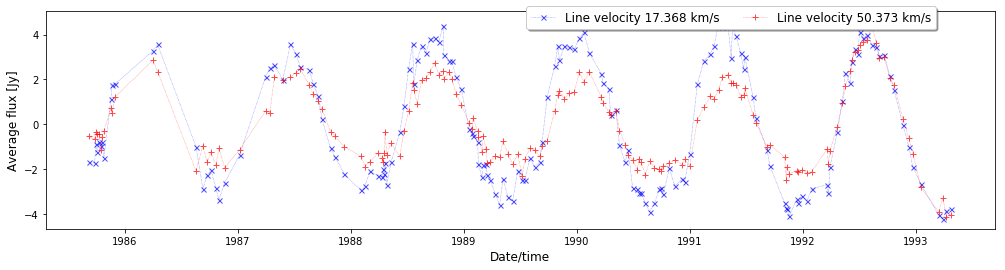

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='b', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.7)
ax.plot(jd_datetime, red_spectrum,
        color='r', marker='+', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.7)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

### Compute the periodogram
Find the best period in days

In [9]:
import periodogram

#from periodogram import lomb_scargle
# we will upsample the signal for CSD calculations
dt = np.diff(ts_jd).min()

[blue_power,
 blue_frequency,
 blue_period,
 blue_time,
 blue_model] = periodogram.lomb_scargle(ts_jd.value,
                            blue_spectrum,
                            dt=dt.value)
blue_time = Time(np.array(blue_time), format=tsformat)

[red_power,
 red_frequency,
 red_period,
 red_time,
 red_model] = periodogram.lomb_scargle(ts_jd.value,
                           red_spectrum,
                           dt=dt.value)
red_time = Time(np.array(red_time), format=tsformat)

In [10]:
print(header)
period = (blue_period+red_period)/2.
print('Blue period = {:.2f} [days]'.format(blue_period))
print('Red period  = {:.2f} [days]'.format(red_period))
print('Avg period  = {:.2f} [days]'.format(period))

print((blue_period-red_period)/2.)

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 50.373

Blue period = 472.58 [days]
Red period  = 472.58 [days]
Avg period  = 472.58 [days]
0.0


Given the assumption of the OH masers on the near and far side of a spherical dust sphere, we would expect the period of the channels to be close to each other, assuming they are equal distance separated from the central start and experiencing the same pumping mechanism.

In [11]:
# relative phase shift between two signals from cross correlation
fs = 1./dt  # Sample frequency 1/d
freq = 1./period  # Frequency in 1/d

# fine tune period calculation
timestamps = ts_jd.value
light_curve = red_spectrum - red_spectrum.mean()

red_model_opt = stats.LombScargle(timestamps, red_spectrum).model(t=timestamps, frequency=freq)
smoothed_curve = red_model_opt - red_model_opt.mean()
residual = light_curve - smoothed_curve
rms = np.sqrt(np.mean(residual**2))
est = (1. - rms)*period
setp = 0.01#0.001
testp = np.arange(period-est, period+est, setp)
phase_fit = np.linspace(0., 1., len(ts_jd.value))
hndle = stats.LombScargle(timestamps, light_curve)
rms = []
for cnt, p in enumerate(testp):
    progress(float(cnt), 50, (float(cnt)/float(len(testp))*100.))
    f = 1./p
    mag_fit =hndle.model(t=ts_jd.value, frequency=f)
    residual = light_curve - mag_fit
    rms.append(np.sqrt(np.mean(residual**2)))
# dummy print for progress
print

err = np.abs(period-testp[np.argmin(rms)]) 
print('Error period pm {:.3f} [days]'.format(err))

29314 [================================================= ] 99% iterations left
Error period pm 3.422 [days]


In [12]:
print(period,testp[np.argmin(rms)])

(472.57645762711843, 469.1539662291496)


In [13]:
period=testp[np.argmin(rms)]

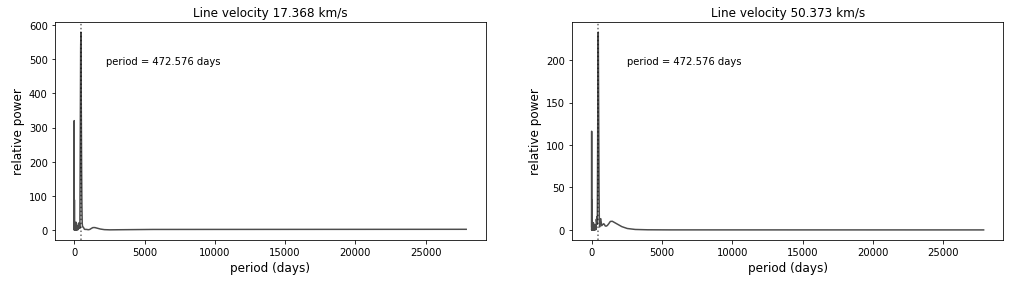

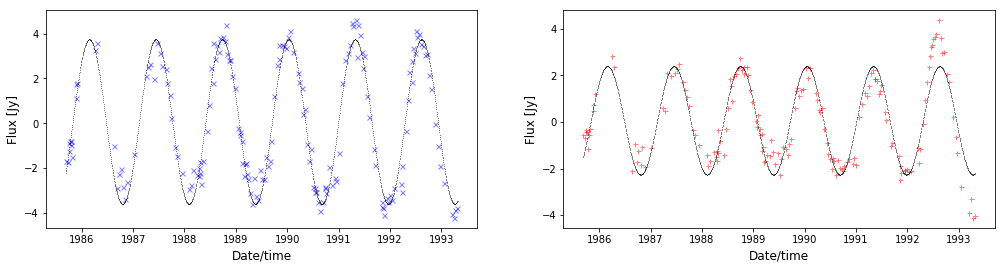

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
period_range = 1./blue_frequency  # period is the inverse of frequency
axs[0].plot(period_range, blue_power, 'k', alpha=0.7)
axs[0].axvline(blue_period, color='k',linestyle=':', alpha=0.6)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))
axs[0].set_xlabel('period (days)', fontsize=12)
axs[0].set_ylabel('relative power', fontsize=12)
axs[0].text(-0.05,0.83,
            'period = {:.3f} days'.format(blue_period),
            transform=ax.transAxes,
            color='k')

period_range = 1./red_frequency  # period is the inverse of frequency
axs[1].plot(period_range, red_power, 'k', alpha=0.7)
axs[1].axvline(red_period, color='k',linestyle=':', alpha=0.6)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))
axs[1].set_xlabel('period (days)', fontsize=12)
axs[1].set_ylabel('relative power', fontsize=12)
axs[1].text(0.5,0.83,
            'period = {:.3f} days'.format(red_period),
            transform=ax.transAxes,
            color='k')

fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
axs[0].plot(jd_datetime, blue_spectrum,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[0].plot(blue_time.datetime, blue_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_ylabel('Flux [Jy]', fontsize=12)

axs[1].plot(jd_datetime, red_spectrum,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[1].plot(red_time.datetime, red_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_ylabel('Flux [Jy]', fontsize=12)

plt.show()

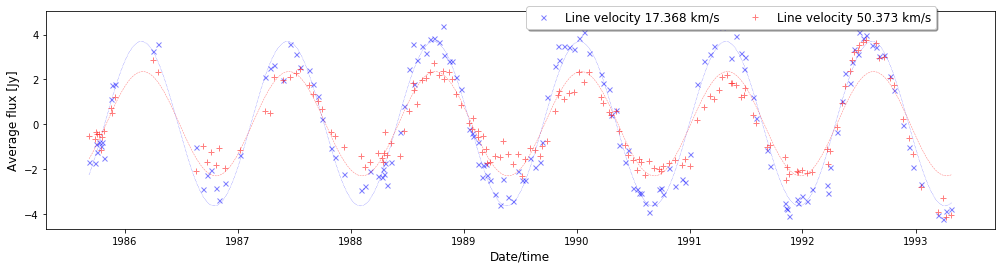

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_spectrum,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

Relation between time delay ($\Delta T$) and phase lag ($\phi$): $2\pi \Delta T = \phi$

In [16]:
# get the models for the averaged period rather than the channel specific period
timestamps = ts_jd.value
diff = np.diff(ts_jd).min()
model_time = periodogram.upsample(timestamps[0], timestamps[-1], diff.value)

blue_model = stats.LombScargle(timestamps, blue_spectrum).model(t=model_time, frequency=freq)
blue_channel = blue_model-blue_model.mean()
red_model = stats.LombScargle(timestamps, red_spectrum).model(t=model_time, frequency=freq)
red_channel = red_model-red_model.mean()

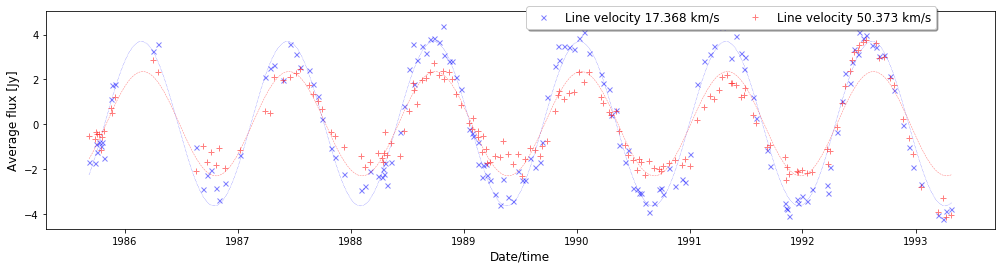

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_spectrum,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

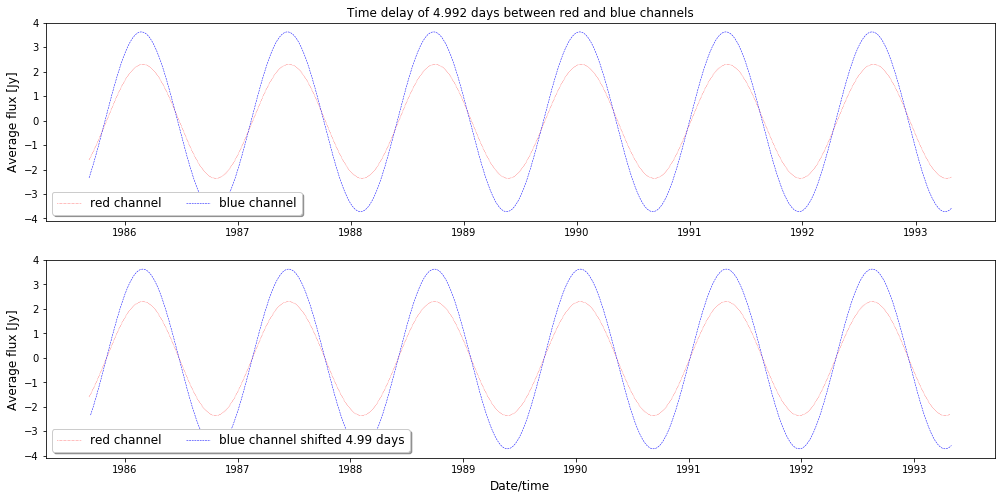

In [18]:
phase_offset_rad=np.arccos(np.dot(blue_channel, red_channel)/(np.linalg.norm(blue_channel)*np.linalg.norm(red_channel)))
time_delay = phase_offset_rad/(2.*np.pi*freq)

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(17, 8),
                        facecolor='white')
axs[0].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
axs[0].plot(blue_time.datetime, blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel')
axs[0].set_title('Time delay of {:.3f} days between red and blue channels'.format(time_delay))
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

axs[1].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
axs[1].plot(blue_time.datetime+timedelta(days=time_delay), blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel shifted {:.2f} days'.format(time_delay))
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)
plt.show()

In [19]:
def get_folded_phase(ts, period):
    """Fold the observation times with the best period of the variable signal."""
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (ts / period) % 1
    return phase

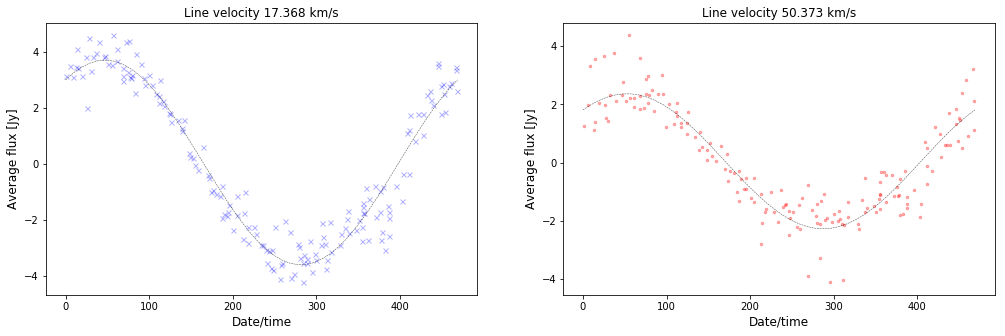

In [20]:
# compute model fitted values
phase_fit = np.linspace(0., 1.)
phase = get_folded_phase(ts_jd.value, period)

blue_mag_fit = stats.LombScargle(
                ts_jd.value, blue_spectrum - blue_spectrum.mean()).model(
                    t=phase_fit * period, frequency=1./period)

red_mag_fit = stats.LombScargle(
                ts_jd.value, red_spectrum - red_spectrum.mean()).model(
                    t=phase_fit * period, frequency=1./period)

# Plot folded lightcurve
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 5),
                        facecolor='white')
axs[0].plot(period*phase, blue_spectrum - blue_spectrum.mean(),
            color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[0].plot(period*phase_fit, blue_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))

axs[1].plot(period*phase, red_spectrum - red_spectrum.mean(),
            color='r', marker='.', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[1].plot(period*phase_fit, red_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))

plt.show()

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/HartRAO_OH_periodogram_calculation.ipynb)

In [ ]:
https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/HartRAO_OH_periodogram_calculation.ipynb